## This is a Julia version of the code for Einstein_Scalar_field

See paper: *On free evolution of self gravitating, spherically symmetric waves.*

Equations in notes.ipynb

In [1]:
using OrdinaryDiffEq
using SummationByPartsOperators
#using DifferentialEquations
using Plots
using LinearAlgebra
#using BandedMatrices
using Printf


In [2]:
include("aux_functions_IR.jl") # here is where the functions are stored.

constraints!

In [94]:
N = 4001 #grid steps
x_i = 1.0; x_f = 100.0 #region 
dx = (x_f-x_i)/(N-1)
U = 5 #number of fields (f,g,h,χ_+,χ_-)

u0 = zeros(N*U) # for the initial data
du = zeros(N*U) # for the time derivatives
C = ones(2N) # for the constraints

#order 6/8 are not working, I get instabilities. Problems with the eigenvalues too big? Does not seem to be so.

#D = derivative_operator(MattssonNordström2004(), derivative_order=1, accuracy_order=8, xmin=x_i, xmax=x_f, N=N)
D = derivative_operator(MattssonAlmquistVanDerWeide2018Accurate(), derivative_order=1, accuracy_order=4, xmin=x_i, xmax=x_f, N=N)
#D = derivative_operator(MattssonAlmquistCarpenter2014Optimal(), derivative_order=1, accuracy_order=4, xmin=x_i, xmax=x_f, N=N)
#D = derivative_operator(Mattsson2017(), derivative_order=1, accuracy_order=8, xmin=x_i, xmax=x_f, N=N)


# one can the get the grid for the D, this is important when the operator has non-uniform grid.
x = SummationByPartsOperators.grid(D)

# the dissipation operator correponding to D
Δ = dissipation_operator(D)
#Δ = 1.0
dT = 1.0*D.Δx
@show dx - D.Δx

dx - D.Δx = -2.4478746125586315e-6


-2.4478746125586315e-6

In [95]:
# put some boundary data
A = 1.0; ω = 2π; τ = 5.0; σ = -0.0
p = (D, Δ, x, dx, A, ω, τ, σ)

f = @view u0[1:N]
g = @view u0[N+1:2N]
h = @view u0[2N+1:3N]
χ₊ = @view u0[3N+1:4N]
χ₋ = @view u0[4N+1:5N]

f .= 1.0;
g .= 1.0;
#rest set to zero

D*f

Δ*f

p

(SBP first-derivative operator of order 4 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Almquist, van der Weide (2018) 
  Boundary optimized diagonal-norm SBP operators ('Accurate'). 
  Journal of Computational Physics 374, pp. 1261-1266., SBP 4-derivative dissipation operator of order 2 on a grid in [1.0, 100.0] using 4001 nodes 
and coefficients of Mattsson, Svärd, Nordström (2004) 
  Stable and Accurate Artificial Dissipation. 
  Journal of Scientific Computing 21.1, pp. 57-79. 
See also (first and second derivatives) 
  Mattsson, Nordström (2004) 
  Summation by parts operators for finite difference approximations of second 
    derivatives. 
  Journal of Computational Physics 199, pp. 503-540., [1.0, 1.0170209084557449, 1.0446091465241036, 1.0693615943987163, 1.0941140422733289, 1.1188664901479415, 1.143618938022554, 1.1683713858971665, 1.193123833771779, 1.2178762816463917  …  99.7821237183536, 99.80687616622821, 99.83162861410283, 99.85638106197743, 9

In [96]:
T=200
prob = ODEProblem(F!,u0,(0.0,T),p);
sol = solve(prob,RK4(),dt=dT,adaptive=false);#,save_everystep=false);

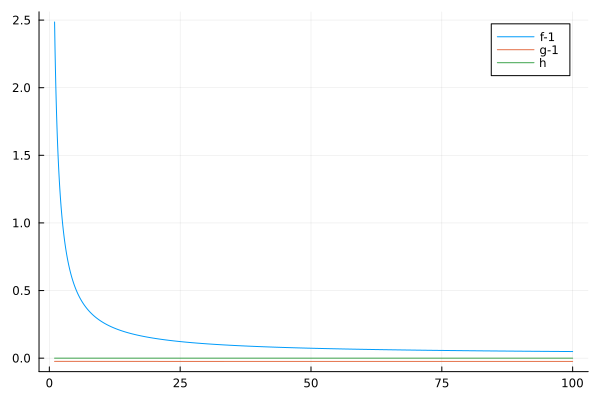

In [86]:
t = 200
plot(x,sol(t)[1:N].-1.0, label = "f-1")
plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
plot!(x,sol(t)[2N+1:3N], label = "h")

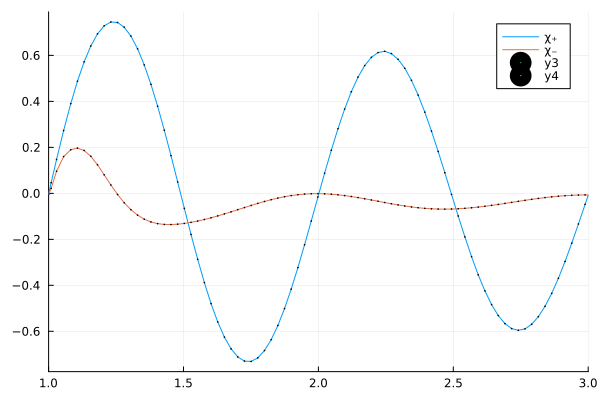

In [64]:
t = 100
plot(x,sol(t)[3N+1:4N], label = "χ₊"
,xlim = (1,3)
)
plot!(x,sol(t)[4N+1:5N], label = "χ₋")
scatter!(x,sol(t)[3N+1:4N],ms=0.5)
scatter!(x,sol(t)[4N+1:5N],ms=0.5)

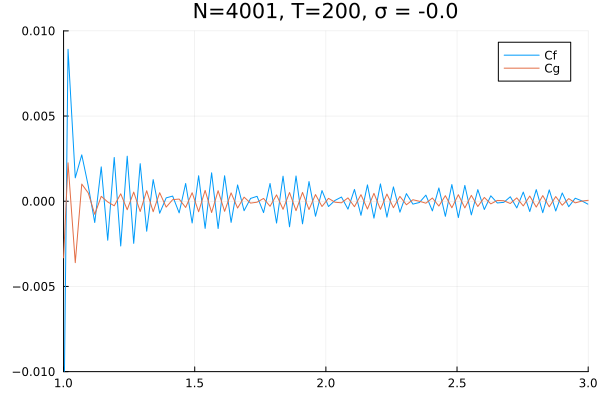

In [102]:
t = 200
constraints!(C,sol(t),D)
plot(title = "N=$N, T=$T, σ = $σ")
plot!(x,C[1:N], label = "Cf"
, xlim = (1.0,3.0)
, ylim = (-0.01,0.01)
)
plot!(x,C[N+1:2N], label = "Cg")
#png("Images/Constraints"*"MAWA_4_T$(T)_N$(N)_S_0p0")

In [104]:
CC(t) = norm(constraints!(C,sol(t),D)[1:end-2])
plot(0:T,t->CC(t), title="Constraints, N=$N, σ=$σ, norm-2pts")
#png("Images/Constraints"*"_MAWA_4_N$(N)_S_0p0")

In [ ]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title=@sprintf("fgh values at t = %6.2f",t))
    #@sprintf("\$t = %6.2f \$", sol.t[idx])
    plot!(x,sol(t)[1:N].-1.0, label = "f-1")
    plot!(x,sol(t)[N+1:2N].-1.0, label = "g-1")
    plot!(x,sol(t)[2N+1:3N], label = "h")
end

gif(anim, "fgh_fps5.gif", fps = 5)

In [ ]:
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="scalar field values at t=$t"
    #, ylim=(-1,1)
    )
    plot!(x,sol(t)[3N+1:4N], label = "χ₊")
    plot!(x,sol(t)[4N+1:5N], label = "χ₋")
end

gif(anim, "scalar_fps5.gif", fps = 5)

In [ ]:
C = zeros(2N)
anim = @animate for i ∈ 1:20
    t = T*i/20
    plot(title="Constraints at t=$t")#, ylim=(-1,1))
    constraints!(C,sol(t),D)
    plot!(x,C[1:N], label = "Cf")
    plot!(x,C[N+1:2N], label = "Cg")
end

gif(anim, "scalar_fps5.gif", fps = 5)

In [ ]:
sol_4_N4001_s01 .= sol